In [1]:
from pathlib import Path
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
project_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_path)
from config import Config
from metric_comps import MetricDataset, resample_raster
config = Config()

In [3]:
year = 2019
compare_metrics_dict = {}
for i in range(0, len(config.modis_metric_names)):
    compare_metrics_dict[f"{year} Band {i + 1}"] = {}
compare_metrics_dict

{'2019 Band 1': {},
 '2019 Band 2': {},
 '2019 Band 3': {},
 '2019 Band 4': {},
 '2019 Band 5': {},
 '2019 Band 6': {},
 '2019 Band 7': {},
 '2019 Band 8': {},
 '2019 Band 9': {},
 '2019 Band 10': {},
 '2019 Band 11': {},
 '2019 Band 12': {}}

In [4]:
for i in range(0, len(config.modis_metric_names)):
    print(f"Loading MODIS metric {i + 1}: {config.modis_metric_names[i]}")
    mds = MetricDataset(config.modis_metric_path, i+1, year, 'modis', 'v6', config.modis_metric_names)
    mds_array, mds_transform = mds.load_tiff()
    compare_metrics_dict[f"{year} Band {i + 1}"]["modis"] = mds_array

Loading MODIS metric 1: first_snow_day
Loading MODIS metric 2: last_snow_day
Loading MODIS metric 3: fss_range
Loading MODIS metric 4: longest_css_first_day
Loading MODIS metric 5: longest_css_last_day
Loading MODIS metric 6: longest_css_day_range
Loading MODIS metric 7: snow_days
Loading MODIS metric 8: no_snow_days
Loading MODIS metric 9: css_segment_num
Loading MODIS metric 10: mflag
Loading MODIS metric 11: cloud_days
Loading MODIS metric 12: tot_css_days


In [5]:
if mds:
    for i in range(0, len(config.modis_metric_names)):
        if config.viirs_metric_names[i] is None:
            continue
        print(f"Loading VIIRS metric {i + 1}: {config.viirs_metric_names[i]}")
        if i == 11:
            band = 10
        else:
            band = i + 1
        vds = MetricDataset(config.viirs_metric_path, band, year, 'viirs', 'v001', config.viirs_metric_names)
        vds_array, vds_transform = resample_raster(mds, vds) #Use resample_raster to warp viirs metrics to modis grid
        compare_metrics_dict[f"{year} Band {i + 1}"]["viirs"] = vds_array

Loading VIIRS metric 1: first_snow_day
Loading VIIRS metric 2: last_snow_day
Loading VIIRS metric 3: fss_range
Loading VIIRS metric 4: longest_css_start
Loading VIIRS metric 5: longest_css_end
Loading VIIRS metric 6: longest_css_range
Loading VIIRS metric 7: snow_days
Loading VIIRS metric 8: no_snow_days
Loading VIIRS metric 9: css_segment_num
Loading VIIRS metric 12: tot_css_days


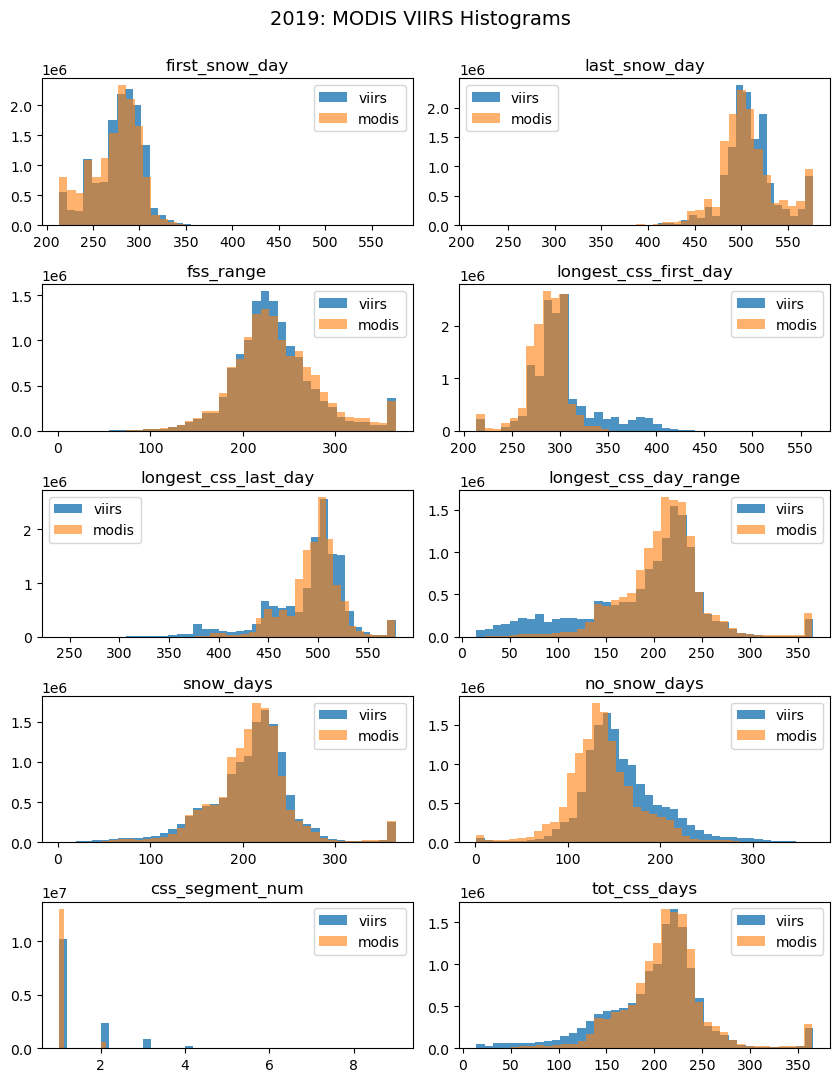

In [6]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8.5, 11))

axes = axes.flatten()

index = 0
for i, (key, values) in enumerate(compare_metrics_dict.items()):

    try:
        viirs_metric = values['viirs']
    except:
        continue
    modis_metric = values['modis']

    viirs_z_mask = np.nonzero(viirs_metric)
    viirs_metric = viirs_metric[viirs_z_mask]
    modis_z_mask = np.nonzero(modis_metric)
    modis_metric = modis_metric[modis_z_mask]

    viirs_hist, viirs_bins = np.histogram(viirs_metric, bins=40)
    modis_hist, modis_bins = np.histogram(modis_metric, bins=40)

    ax = axes[index]
    ax.hist(viirs_metric.flatten(), bins=viirs_bins, alpha=0.8, label='viirs')
    ax.hist(modis_metric.flatten(), bins=modis_bins, alpha=0.6, label='modis')

    ax.set_title(config.modis_metric_names[i])
    ax.legend()

    index += 1


plt.suptitle(f'{year}: MODIS VIIRS Histograms', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
#plt.savefig(Path(stats_output_dir) / f"{year}_viirs_and_modis_histograms_no_zeros.png", dpi=300, bbox_inches="tight")